# **Parameter Setup**

In [ ]:
# Install required libraries (if not already installed)
!pip install pytorch-lightning wandb
!pip install pytorch-lightning -U -qq
!pip install torchmetrics -U -qq
!pip install fastdownload -U -qq
!pip install fastai -U -qq
!pip install wandb -U -qq

# Import libraries
import os
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torchmetrics
import wandb
from pytorch_lightning.loggers import WandbLogger
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
from pytorch_lightning import seed_everything
from pytorch_lightning.tuner import Tuner
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
import gc


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 117.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.5/314.5 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.8 MB/s eta 0:00:00


In [ ]:
# Hyperparameters
LEARNING_RATE = 1e-3
NUM_EPOCHS = 30
train_image_folder = '/content/data/train'

layers_to_unfreeze = ['classifier']

# Setup environment

## Github

In [1]:
# Install Git if not already installed
!apt-get install git

# Set up user details (use your GitHub username and email)
!git config --global user.name "siddheshcn"
!git config --global user.email "iamsid.234@gmail.com"

# Clone the repository
!git clone https://github.com/siddheshcn/diabetic-retinopathy-classification-multiclass

# Navigate to the cloned repository
%cd diabetic-retinopathy-classification-multiclass

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Cloning into 'diabetic-retinopathy-classification-multiclass'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (4/4), done.
/content/diabetic-retinopathy-classification-multiclass


In [2]:
from shutil import copyfile

# Replace 'kaggleDR_multiclass.ipynb' with the actual file name of your notebook
copyfile('/content/kaggleDR_multiclass.ipynb', '/content/diabetic-retinopathy-classification-multiclass/kaggleDR_multiclass.ipynb')

FileNotFoundError: [Errno 2] No such file or directory: '/content/kaggleDR_multiclass.ipynb'

In [ ]:
import os

# Retrieve the token from Colab secrets
GIT_TOKEN = os.getenv("git_token")

# Add the changes
!git add kaggleDR_multiclass.ipynb

# Commit the changes (use a descriptive message)
!git commit -m "Initial commit of the diabetic retinopathy notebook"

# Push the changes
!git push https://{GIT_TOKEN}@github.com/siddheshcn/diabetic-retinopathy-classification-multiclass.git

In [ ]:
def save_and_push(file_path, commit_message):
    from shutil import copyfile
    import os

    # Retrieve the token from Colab secrets
    GIT_TOKEN = os.getenv("git_token")

    # Copy the notebook file to the repository directory
    copyfile(file_path, '/content/diabetic-retinopathy-classification-multiclass/' + file_path.split('/')[-1])

    # Add, commit, and push the changes
    !git add .
    !git commit -m "{commit_message}"
    !git push https://{GIT_TOKEN}@github.com/siddheshcn/diabetic-retinopathy-classification-multiclass.git

# Usage:
save_and_push('/content/kaggleDR_multiclass.ipynb', 'Updated notebook with latest changes')

## Environment

In [3]:
from pathlib import Path
import sys

if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    base_folder = Path('/content/drive/MyDrive/sidmeister/')
    data_folder = Path('/content')

else:
    base_folder = Path('base_folder path error')
    data_folder = Path('data_folder path error')


Mounted at /content/drive


In [ ]:
custom_function_folder = base_folder/'modular_dl/custom-functions/'
model_folder = base_folder/'modular_dl/kaggleDR/model'
model_folder.mkdir(parents=True, exist_ok=True)
project_folder = base_folder/'kaggleDR'
kaggle_api_folder = base_folder/'modular_dl/kaggleDR/env_files/.kaggle'
sys.path.append(str(project_folder))
sys.path.append(str(custom_function_folder))

In [ ]:


#from data_module_kaggleDR import FashionMNISTDataModule #############################################################
#from multiclass_lightning_module import MultiClassLightningModule
#from model_two_layer_bn import TwoLayerMLPBN

# Dataset Setup


In [ ]:
#download data from kaggle competition
#!mkdir ~/.kaggle
#!cp /content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/env_files/.kaggle/kaggle.json ~/.kaggle/kaggle.json
#!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
# fast download dataset from kaggle competitions download -c diabetic-retinopathy-detection
#!kaggle competitions download -c diabetic-retinopathy-detection

In [ ]:
#copy downloaded dataset to base_folder/'modular_dl/kaggleDR/dataset/raw'
#!cp -r diabetic-retinopathy-detection.zip /content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/dataset/raw


In [ ]:
#unzip diabetic-retinopathy-detection.zip
#!unzip /content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/dataset/raw/diabetic-retinopathy-detection.zip -d /content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/dataset/unzip

In [ ]:
#concatenate zip parts together as train.zip
#!cat /content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/dataset/unzip/train.zip.* > /content/train.zip

In [ ]:
#copy train.zip to raw
!mkdir -p /content/data
!cp /content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/dataset/train_set/train.zip  /content/

In [ ]:
!mkdir -p /content/data
!unzip train.zip -d /content/data


Streaming output truncated to the last 5000 lines.
  inflating: /content/data/train/44261_left.jpeg  
  inflating: /content/data/train/44261_right.jpeg  
  inflating: /content/data/train/44262_left.jpeg  
  inflating: /content/data/train/44262_right.jpeg  
  inflating: /content/data/train/44263_left.jpeg  
  inflating: /content/data/train/44263_right.jpeg  
  inflating: /content/data/train/44264_left.jpeg  
  inflating: /content/data/train/44264_right.jpeg  
  inflating: /content/data/train/44265_left.jpeg  
  inflating: /content/data/train/44265_right.jpeg  
  inflating: /content/data/train/44267_left.jpeg  
  inflating: /content/data/train/44267_right.jpeg  
  inflating: /content/data/train/44268_left.jpeg  
  inflating: /content/data/train/44268_right.jpeg  
  inflating: /content/data/train/44275_left.jpeg  
  inflating: /content/data/train/44275_right.jpeg  
  inflating: /content/data/train/44278_left.jpeg  
  inflating: /content/data/train/44278_right.jpeg  
  inflating: /content/

In [ ]:
#copy trainlabels.csv.zip then extract and load
!mkdir -p /content/data
!cp /content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/dataset/unzip/trainLabels.csv.zip  /content
!unzip trainLabels.csv.zip -d /content/data

Archive:  trainLabels.csv.zip
  inflating: /content/data/trainLabels.csv  


In [ ]:
#load trainlabels.csv as dataset
import pandas as pd
df = pd.read_csv('/content/data/trainLabels.csv')
df.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [ ]:
# prompt: based on image column, add two more columns, patient_id and eye


def extract_patient_id_and_eye(image_name):
  """Extracts patient ID and eye information from the image name."""
  patient_id = image_name.split('_')[0]
  eye = image_name.split('_')[1]
  return patient_id, eye

# Add new columns to the DataFrame
df['patient_id'] = df['image'].apply(lambda x: extract_patient_id_and_eye(x)[0])
df['eye'] = df['image'].apply(lambda x: extract_patient_id_and_eye(x)[1])

df.head()


,image,level,patient_id,eye
0,10_left,0,10,left
1,10_right,0,10,right
2,13_left,0,13,left
3,13_right,0,13,right
4,15_left,1,15,left


# EDA

In [ ]:
#count the number of images in train dataset

#find out unique patient ID

#proportion of patients with both their eyes in dataset

#do both eyes have same level of DR

#setup labels in a csv

#vizualize dataset distribution

#Devise plan for managine imbalance if any

#

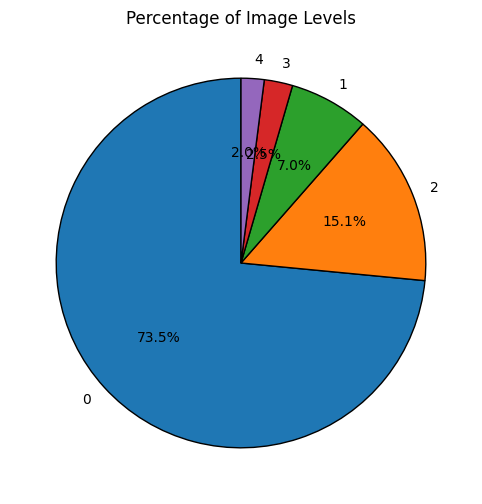

In [ ]:
# @title Percentage of image levels

import matplotlib.pyplot as plt

level_counts = df['level'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(level_counts, labels=level_counts.index, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
_ = plt.title('Percentage of Image Levels')


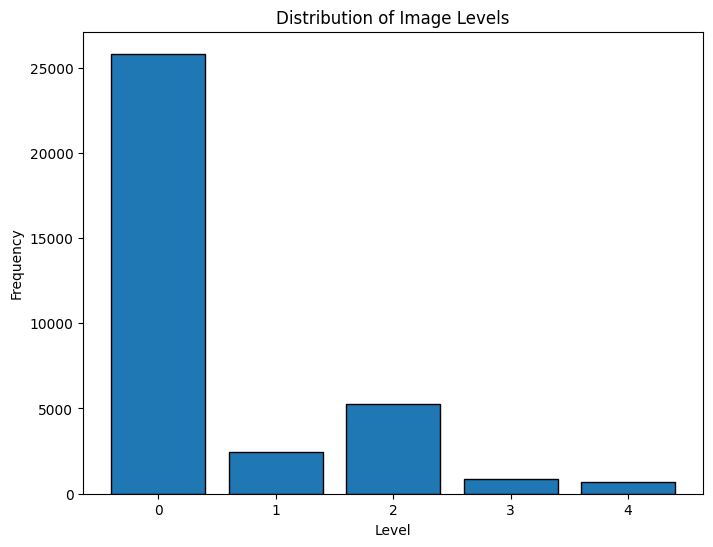

In [ ]:
# @title Distribution of Image Levels

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(df['level'], bins=range(6), align='left', rwidth=0.8, edgecolor='black')
plt.xlabel('Level')
plt.ylabel('Frequency')
_ = plt.title('Distribution of Image Levels')

In [ ]:
#count the number of images in /content/data/train

train_image_folder = '/content/data/train'
image_count = len([name for name in os.listdir(train_image_folder) if os.path.isfile(os.path.join(train_image_folder, name))])

print(f"Number of images in {train_image_folder}: {image_count}")


Number of images in /content/data/train: 35126


In [ ]:
#count unique level frequency

unique_level_counts = df['level'].value_counts()
print(unique_level_counts)

level
0    25810
2     5292
1     2443
3      873
4      708
Name: count, dtype: int64


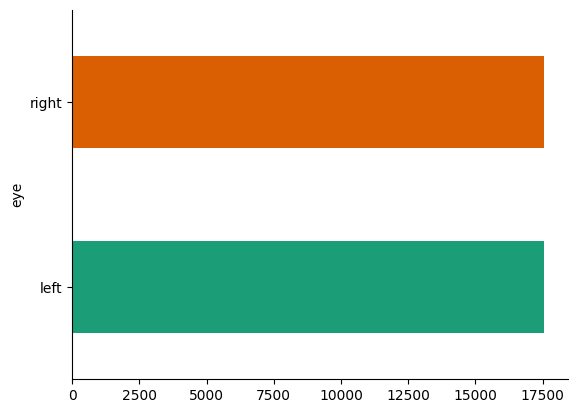

In [ ]:
# @title eye

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('eye').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# prompt: check how many patient_ids have only one eye in the dataset?

patient_eye_counts = df.groupby('patient_id')['eye'].nunique()
single_eye_patients = patient_eye_counts[patient_eye_counts == 1].count()
print(f"Number of patients with only one eye in the dataset: {single_eye_patients}")


Number of patients with only one eye in the dataset: 0


Level: 0


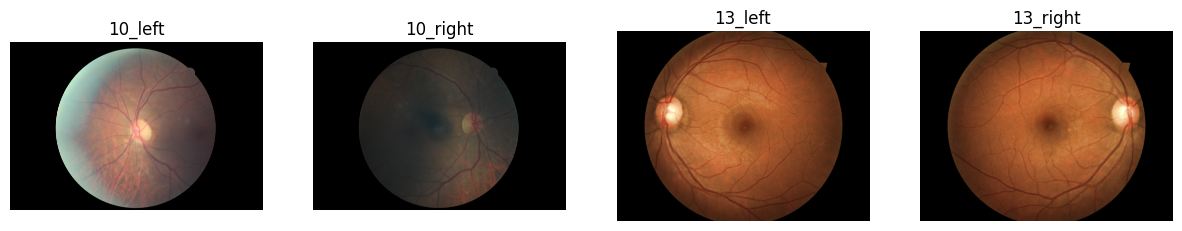

Level: 1


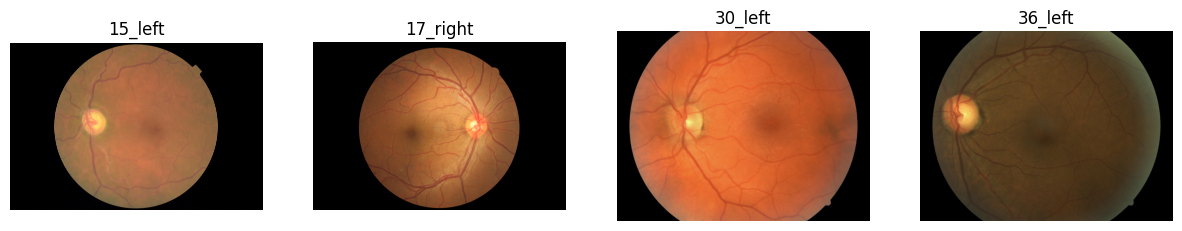

Level: 2


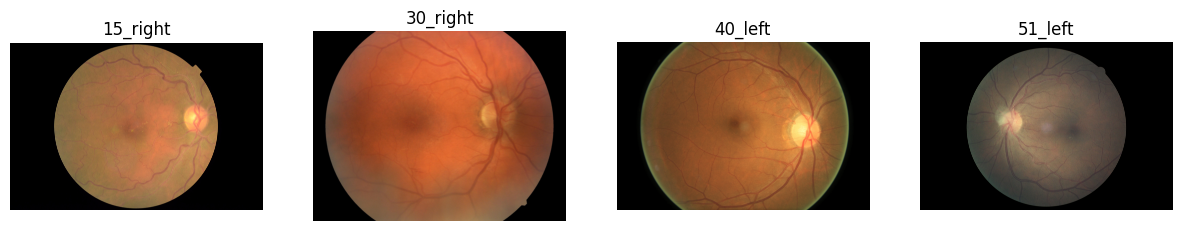

Level: 4


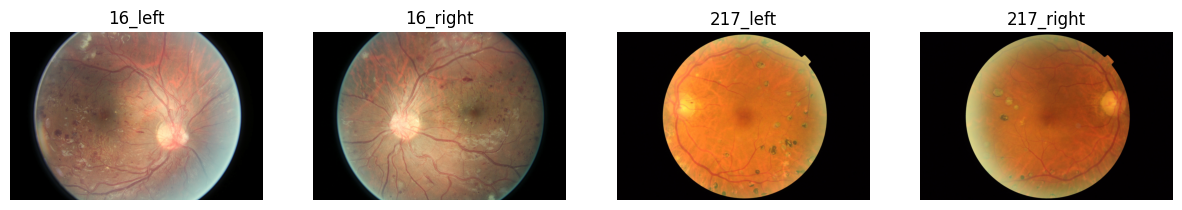

Level: 3


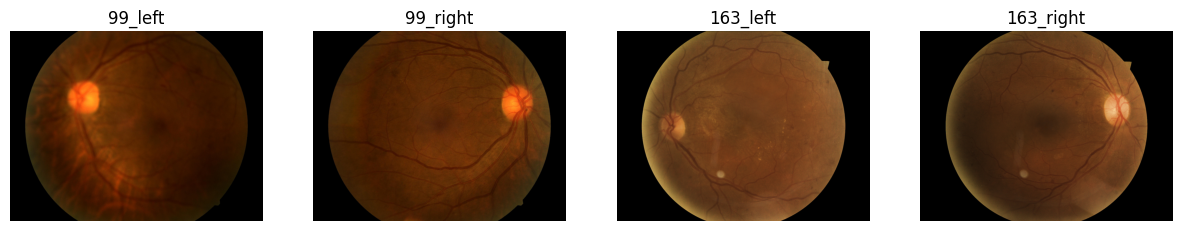

In [ ]:
# prompt: display 4 samples each of each of the levels with their filename

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Group the DataFrame by 'level'
for level in df['level'].unique():
  print(f"Level: {level}")
  # Get filenames for images with this level
  filenames = df[df['level'] == level]['image'].tolist()[:4]

  # Display images
  fig, axes = plt.subplots(1, len(filenames), figsize=(15, 5))
  for i, filename in enumerate(filenames):
      img_path = os.path.join(train_image_folder, filename + '.jpeg')
      try:
          img = mpimg.imread(img_path)
          axes[i].imshow(img)
          axes[i].set_title(filename)
          axes[i].axis('off')
      except FileNotFoundError:
          print(f"File not found: {img_path}")
  plt.show()



# Creating Training, Validation, and Test Datasets
---

## Define Image Transformation

In [ ]:
# Define image transformations
IMG_SIZE = 300
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

## DRDataset : Custom dataset class

In [ ]:
class DRDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.labels_df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.labels_df.iloc[idx]['image'] + '.jpeg')
        image = Image.open(img_name).convert('RGB')
        label = int(self.labels_df.iloc[idx]['level'])
        if self.transform:
            image = self.transform(image)
        return image, label

## Create Datasets and Dataloaders

In [ ]:
# Create datasets
full_dataset = DRDataset(df=df, img_dir='/content/data/train', transform=train_transforms)

# Split dataset into training, validation, and test sets
train_size = int(0.7 * len(full_dataset))
valid_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = random_split(full_dataset, [train_size, valid_size, test_size])

# Update transforms for validation and test datasets
valid_dataset.dataset.transform = valid_transforms
test_dataset.dataset.transform = valid_transforms

# Create dataloaders
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [ ]:
df.head()


,image,level,patient_id,eye
0,10_left,0,10,left
1,10_right,0,10,right
2,13_left,0,13,left
3,13_right,0,13,right
4,15_left,1,15,left


## Class weight Assignments
Compute class weights to handle class imbalance

In [ ]:
import numpy as np

# Get the labels from the dataset
labels = df['level'].values

# Compute class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights = torch.tensor(class_weights, dtype=torch.float)
print("Class Weights:", class_weights)

Class Weights: tensor([0.2722, 2.8756, 1.3275, 8.0472, 9.9226])


# Function to load the model

## Define the model once

In [ ]:
# Load the pre-trained EfficientNet-B3 model
model = models.efficientnet_b3(weights='IMAGENET1K_V1')

# Modify the classifier
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_features, 5)
)

# Check for GPU availability and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the appropriate device
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

## Function for Freezing and Unfreezing Layers
The function set_parameter_requires_grad freezes all parameters and then unfreezes only the specified layers.

In [ ]:
def set_parameter_requires_grad(model, layers_to_unfreeze=None):
    """
    Freeze all layers in the model except those in layers_to_unfreeze.

    Args:
        model (nn.Module): The model.
        layers_to_unfreeze (list of str): List of layer names to unfreeze.
    """
    # First, freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # If layers_to_unfreeze is None or empty, only the classifier will be trainable
    if layers_to_unfreeze is None:
        # Unfreeze the classifier
        for param in model.classifier.parameters():
            param.requires_grad = True
            print('Unfreeze: Classifier')
    else:
        # Unfreeze specified layers
        for name, module in model.named_modules():
            if any(layer_name in name for layer_name in layers_to_unfreeze):
                for param in module.parameters():
                    param.requires_grad = True
            print('Unfreezing layers:', layers_to_unfreeze)

# New Appoach

## DRClassifier - PyTorch Lightening Module

In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torchmetrics
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

class DRClassifier(pl.LightningModule):
    def __init__(self, model, class_weights, learning_rate=1e-3):
        super().__init__()
        self.model = model  # The pre-trained EfficientNet-B3 model with a custom classifier
        self.criterion = nn.CrossEntropyLoss(weight=class_weights)  # Loss function with class weights
        self.learning_rate = learning_rate  # Initial learning rate

        # Metrics to track accuracy for training and validation
        self.train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=5)
        self.val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=5)

    def forward(self, x):
        """ Forward pass through the model """
        return self.model(x)

    def training_step(self, batch, batch_idx):
        """
        Defines the training loop logic.
        - Forward pass
        - Compute loss and accuracy
        - Log metrics
        """
        images, labels = batch
        images = images.to(self.device)
        labels = labels.to(self.device).long()

        # Forward pass
        outputs = self(images)
        loss = self.criterion(outputs, labels)

        # Compute accuracy
        preds = torch.argmax(outputs, dim=1)
        acc = self.train_accuracy(preds, labels)

        # Log metrics
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True)

        # Log learning rate
        optimizer = self.optimizers()
        lr = optimizer.param_groups[0]['lr']  # Extract the learning rate
        self.log('learning_rate', lr, on_step=False, on_epoch=True, prog_bar=True)  # Log the learning rate

        return loss

    def validation_step(self, batch, batch_idx):
        """
        Defines the validation loop logic.
        - Forward pass
        - Compute loss and accuracy
        - Log metrics
        """
        images, labels = batch
        images = images.to(self.device)
        labels = labels.to(self.device).long()

        # Forward pass
        outputs = self(images)
        loss = self.criterion(outputs, labels)

        # Compute accuracy
        preds = torch.argmax(outputs, dim=1)
        acc = self.val_accuracy(preds, labels)

        # Log metrics
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def configure_optimizers(self):
        """
        Defines the optimizer and learning rate scheduler.
        """
        # Adam optimizer with filtered parameters (only those that require gradients)
        optimizer = Adam(filter(lambda p: p.requires_grad, self.parameters()), lr=self.learning_rate)

        # Learning rate scheduler that reduces learning rate when validation loss plateaus
        scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.2, min_lr=1e-6)

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',
                'interval': 'epoch',
                'frequency': 1,
                'strict': True
            }
        }

In [ ]:
best_model_path

'/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage7/epoch=09-val_loss=1.16.ckpt'

## Training Function for each stage
	•	The function train_model_stage takes in various parameters and trains the model for one stage.
	•	It sets the requires_grad for the specified layers.
	•	It initializes the DRClassifier with the updated model.
	•	It defines callbacks for checkpointing and early stopping.
	•	It trains the model and returns the path to the best model.

In [ ]:
def train_model_stage(model, train_loader, valid_loader, class_weights, learning_rate, layers_to_unfreeze, num_epochs, stage_name):
    # Set requires_grad for layers
    set_parameter_requires_grad(model, layers_to_unfreeze)

    # Move class_weights to the correct device before instantiating DRClassifier
    class_weights = class_weights.to(device)  # Use the global 'device' variable

    # Instantiate the LightningModule
    dr_classifier = DRClassifier(model=model, class_weights=class_weights)
    dr_classifier.learning_rate = learning_rate

    # Define callbacks
    checkpoint_callback = ModelCheckpoint(
        dirpath=f'/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/{stage_name}/',
        filename='{epoch:02d}-{val_loss:.2f}',
        save_top_k= 5, #Save only the top 5 models
        verbose=True,
        monitor='val_loss',
        mode='min',
        save_weights_only=False,  # Save the entire model, not just weights
        every_n_epochs=1  # Save every epoch
    )
    early_stopping_callback = EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=True,
        mode='min'
    )
    # Initialize WandbLogger
    wandb_logger = WandbLogger(
        project='Multiclass-DR_1017',  # Set your Wandb project name here
        name=f'ENB3_{stage_name}',  # Run name includes the current stage
        log_model='all'  # Log all model checkpoints
    )

    # Define the trainer
    trainer = pl.Trainer(
        max_epochs=num_epochs,
        callbacks=[checkpoint_callback, early_stopping_callback],
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1 if torch.cuda.is_available() else None,
        logger=wandb_logger,
    )

    # Train the model
    trainer.fit(dr_classifier, train_loader, valid_loader)

    # Properly close Wandb run
    try:
        wandb.finish()
    except wandb.errors.UsageError as e:
        print(f"Error closing Wandb: {e}")

    # Return the path and epoch of the best model
    best_model_path = checkpoint_callback.best_model_path
    #best_epoch = int(best_model_path.split('-')[0].split('/')[-1].split('=')[-1])  # Extract the epoch from the filename
    return best_model_path #, best_epoch

In [ ]:
import wandb
wandb.login()


True

## Define Training Pipeline
	-	The stages list defines each training stage with:
	  •	name: Stage name.
	  •	layers_to_unfreeze: Layers to unfreeze in this stage.
	  •	learning_rate: Learning rate for this stage.
	  •	num_epochs: Number of epochs to train in this stage.
	-	The loop goes through each stage:
	  •	If there’s a best_model_path from the previous stage, it loads that model’s weights.
	  •	It calls train_model_stage to train for the current stage.
	  •	Updates best_model_path with the path to the best model from this stage.

In [ ]:
# List of stages with layers to unfreeze and learning rates
stages = [
    {'name': 'stage_class', 'layers_to_unfreeze': None, 'learning_rate': 1e-3, 'num_epochs': 30},
    {'name': 'stage8', 'layers_to_unfreeze': ['features.8'], 'learning_rate': 1e-4, 'num_epochs': 30},
    {'name': 'stage7', 'layers_to_unfreeze': ['features.8', 'features.7'], 'learning_rate': 1e-5, 'num_epochs': 30},
    #{'name': 'stage6', 'layers_to_unfreeze': ['features.8', 'features.7', 'features.6'], 'learning_rate': 1e-5, 'num_epochs': 30},
    # Add more stages as needed
]

best_model_path = '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/model/best_model.ckpt'

for stage in stages:
    print(f"Starting {stage['name']}...")

    # If there's a best model from previous stage, load it
    if best_model_path:
        # Load the best model weights
        dr_classifier = DRClassifier.load_from_checkpoint(
            checkpoint_path=best_model_path,
            model=model,
            class_weights=class_weights
        )
        model = dr_classifier.model  # Update the model with loaded weights
        model.to(device)
        print(f"Loaded best model from {best_model_path}")

    # Train the model for this stage
    best_model_path = train_model_stage(
        model=model,
        train_loader=train_loader,
        valid_loader=valid_loader,
        class_weights=class_weights,
        learning_rate=stage['learning_rate'],
        layers_to_unfreeze=stage['layers_to_unfreeze'],
        num_epochs=stage['num_epochs'],
        stage_name=stage['name']
    )
    best_epoch = 999
    try:
    # Extract the epoch from the filename, assuming the format is consistent.
      best_epoch = int(best_model_path.split('-')[0].split('/')[-1].split('=')[-1])
    except Exception as e:
    # Handle the case where the extraction fails
      print("Failed to extract Best Epoch:", e)


    # Output the best model information
    print(f"Best model saved from Epoch number {best_epoch} at {best_model_path}")

Starting stage_class...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Loaded best model from /content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/model/best_model.ckpt
Unfreeze: Classifier
Unfreeze: Classifier


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | EfficientNet       | 10.7 M | train
1 | criterion      | CrossEntropyLoss   | 0      | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | val_accuracy   | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
7.7 K     Trainable params
10.7 M    Non-trainable params
10.7 M    Total params
42.816    Total estimated model params size (MB)
536       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 1.629
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 385: 'val_loss' reached 1.62865 (best 1.62865), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage_class/epoch=00-val_loss=1.63.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.157 >= min_delta = 0.0. New best score: 1.471
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 770: 'val_loss' reached 1.47147 (best 1.47147), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage_class/epoch=01-val_loss=1.47.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.452
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1155: 'val_loss' reached 1.45171 (best 1.45171), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage_class/epoch=02-val_loss=1.45.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.057 >= min_delta = 0.0. New best score: 1.395
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1540: 'val_loss' reached 1.39453 (best 1.39453), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage_class/epoch=03-val_loss=1.39.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 1.345
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1925: 'val_loss' reached 1.34474 (best 1.34474), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage_class/epoch=04-val_loss=1.34.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.319
INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 2310: 'val_loss' reached 1.31921 (best 1.31921), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage_class/epoch=05-val_loss=1.32.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.315
INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 2695: 'val_loss' reached 1.31535 (best 1.31535), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage_class/epoch=06-val_loss=1.32.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 3080: 'val_loss' reached 1.33006 (best 1.31535), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage_class/epoch=07-val_loss=1.33.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 1.288
INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 3465: 'val_loss' reached 1.28815 (best 1.28815), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage_class/epoch=08-val_loss=1.29.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.273
INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 3850: 'val_loss' reached 1.27321 (best 1.27321), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage_class/epoch=09-val_loss=1.27.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.270
INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 4235: 'val_loss' reached 1.26954 (best 1.26954), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage_class/epoch=10-val_loss=1.27.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 4620: 'val_loss' reached 1.28340 (best 1.26954), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage_class/epoch=11-val_loss=1.28.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 5005: 'val_loss' reached 1.28398 (best 1.26954), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage_class/epoch=12-val_loss=1.28.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.266
INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 5390: 'val_loss' reached 1.26556 (best 1.26556), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage_class/epoch=13-val_loss=1.27.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.259
INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 5775: 'val_loss' reached 1.25940 (best 1.25940), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage_class/epoch=14-val_loss=1.26.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 6160: 'val_loss' reached 1.26273 (best 1.25940), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage_class/epoch=15-val_loss=1.26.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.258
INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 6545: 'val_loss' reached 1.25759 (best 1.25759), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage_class/epoch=16-val_loss=1.26.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.257
INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 6930: 'val_loss' reached 1.25719 (best 1.25719), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage_class/epoch=17-val_loss=1.26.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.252
INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 7315: 'val_loss' reached 1.25201 (best 1.25201), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage_class/epoch=18-val_loss=1.25.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 7700: 'val_loss' reached 1.25478 (best 1.25201), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage_class/epoch=19-val_loss=1.25.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 8085: 'val_loss' reached 1.25341 (best 1.25201), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage_class/epoch=20-val_loss=1.25.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.251
INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 8470: 'val_loss' reached 1.25114 (best 1.25114), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage_class/epoch=21-val_loss=1.25.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 8855: 'val_loss' reached 1.25427 (best 1.25114), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage_class/epoch=22-val_loss=1.25.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.248
INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 9240: 'val_loss' reached 1.24815 (best 1.24815), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage_class/epoch=23-val_loss=1.25.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.247
INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 9625: 'val_loss' reached 1.24746 (best 1.24746), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage_class/epoch=24-val_loss=1.25.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.242
INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 10010: 'val_loss' reached 1.24208 (best 1.24208), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage_class/epoch=25-val_loss=1.24.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.229
INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 10395: 'val_loss' reached 1.22858 (best 1.22858), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage_class/epoch=26-val_loss=1.23.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 10780: 'val_loss' reached 1.23349 (best 1.22858), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage_class/epoch=27-val_loss=1.23.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 11165: 'val_loss' reached 1.24360 (best 1.22858), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage_class/epoch=28-val_loss=1.24.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 11550: 'val_loss' was not in top 5
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▃▄▄▅▅▆▆▆▇▇▇▇██▇▇▇█▇▇███▇█████
train_loss,█▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇█████
val_acc,▁▃▇▅▂▃▄▂▄▆▆▅▆▃▄▄▆▇▅▂▁▆▆▅█▅▄▄▃▇
val_loss,█▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂
epoch,29
learning_rate,0.001
train_acc,0.4043
train_loss,1.27738


Best model saved from Epoch number 26 at /content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage_class/epoch=26-val_loss=1.23.ckpt
Starting stage8...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Loaded best model from /content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage_class/epoch=26-val_loss=1.23.ckpt
Unfreezing layers: ['features.8']
Unfreezing layers: ['features.8']
Unfreezing layers: ['features.8']
Unfreezing layers: ['features.8']
Unfreezing layers: ['features.8']
Unfreezing layers: ['features.8']


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | EfficientNet       | 10.7 M | train
1 | criterion      | CrossEntropyLoss   | 0      | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | val_accuracy   | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
592 K     Trainable params
10.1 M    Non-trainable params
10.7 M    Total params
42.816    Total estimated model params size (MB)
536       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 1.220
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 385: 'val_loss' reached 1.21994 (best 1.21994), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage8/epoch=00-val_loss=1.22.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 770: 'val_loss' reached 1.22478 (best 1.21994), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage8/epoch=01-val_loss=1.22.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.207
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1155: 'val_loss' reached 1.20699 (best 1.20699), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage8/epoch=02-val_loss=1.21.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1540: 'val_loss' reached 1.20899 (best 1.20699), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage8/epoch=03-val_loss=1.21.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.200
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1925: 'val_loss' reached 1.19960 (best 1.19960), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage8/epoch=04-val_loss=1.20.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.196
INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 2310: 'val_loss' reached 1.19603 (best 1.19603), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage8/epoch=05-val_loss=1.20.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.194
INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 2695: 'val_loss' reached 1.19394 (best 1.19394), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage8/epoch=06-val_loss=1.19.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.193
INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 3080: 'val_loss' reached 1.19263 (best 1.19263), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage8/epoch=07-val_loss=1.19.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.189
INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 3465: 'val_loss' reached 1.18889 (best 1.18889), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage8/epoch=08-val_loss=1.19.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 3850: 'val_loss' reached 1.19440 (best 1.18889), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage8/epoch=09-val_loss=1.19.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.185
INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 4235: 'val_loss' reached 1.18534 (best 1.18534), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage8/epoch=10-val_loss=1.19.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 4620: 'val_loss' reached 1.18837 (best 1.18534), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage8/epoch=11-val_loss=1.19.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.177
INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 5005: 'val_loss' reached 1.17690 (best 1.17690), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage8/epoch=12-val_loss=1.18.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 5390: 'val_loss' reached 1.18596 (best 1.17690), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage8/epoch=13-val_loss=1.19.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 5775: 'val_loss' was not in top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 6160: 'val_loss' reached 1.18517 (best 1.17690), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage8/epoch=15-val_loss=1.19.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 6545: 'val_loss' reached 1.18576 (best 1.17690), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage8/epoch=16-val_loss=1.19.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 1.177. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 6930: 'val_loss' reached 1.18137 (best 1.17690), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage8/epoch=17-val_loss=1.18.ckpt' as top 5


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
learning_rate,█████████████████▁
train_acc,▁▂▃▃▄▄▄▅▅▅▅▆▆▇▇▇██
train_loss,█▇▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
val_acc,▂▄▂▂▅▄▃▁▅▇▃▅▇▅▅▇▇█
val_loss,▇█▅▆▄▄▃▃▃▄▂▃▁▂▃▂▂▂
epoch,17
learning_rate,2e-05
train_acc,0.4852
train_loss,1.00597


Best model saved from Epoch number 12 at /content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage8/epoch=12-val_loss=1.18.ckpt
Starting stage7...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Loaded best model from /content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage8/epoch=12-val_loss=1.18.ckpt
Unfreezing layers: ['features.8', 'features.7']
Unfreezing layers: ['features.8', 'features.7']
Unfreezing layers: ['features.8', 'features.7']
Unfreezing layers: ['features.8', 'features.7']
Unfreezing layers: ['features.8', 'features.7']
Unfreezing layers: ['features.8', 'features.7']
Unfreezing layers: ['features.8', 'features.7']
Unfreezing layers: ['features.8', 'features.7']
Unfreezing layers: ['features.8', 'features.7']
Unfreezing layers: ['features.8', 'features.7']
Unfreezing layers: ['features.8', 'features.7']
Unfreezing layers: ['features.8', 'features.7']
Unfreezing layers: ['features.8', 'features.7']
Unfreezing layers: ['features.8', 'features.7']
Unfreezing layers: ['features.8', 'features.7']
Unfreezing layers: ['features.8', 'features.7']
Unfreezing layers: ['features.8', 'features.7']
Unfreezing layers: ['features.8', 'features.7']
Unfreezing l

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | EfficientNet       | 10.7 M | train
1 | criterion      | CrossEntropyLoss   | 0      | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | val_accuracy   | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
3.9 M     Trainable params
6.8 M     Non-trainable params
10.7 M    Total params
42.816    Total estimated model params size (MB)
536       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 1.169
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 385: 'val_loss' reached 1.16896 (best 1.16896), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage7/epoch=00-val_loss=1.17.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 770: 'val_loss' reached 1.17416 (best 1.16896), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage7/epoch=01-val_loss=1.17.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1155: 'val_loss' reached 1.17249 (best 1.16896), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage7/epoch=02-val_loss=1.17.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.169
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1540: 'val_loss' reached 1.16867 (best 1.16867), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage7/epoch=03-val_loss=1.17.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.160
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1925: 'val_loss' reached 1.15996 (best 1.15996), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage7/epoch=04-val_loss=1.16.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 2310: 'val_loss' reached 1.16733 (best 1.15996), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage7/epoch=05-val_loss=1.17.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 2695: 'val_loss' reached 1.17229 (best 1.15996), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage7/epoch=06-val_loss=1.17.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.152
INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 3080: 'val_loss' reached 1.15213 (best 1.15213), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage7/epoch=07-val_loss=1.15.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 3465: 'val_loss' reached 1.16168 (best 1.15213), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage7/epoch=08-val_loss=1.16.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 3850: 'val_loss' reached 1.15570 (best 1.15213), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage7/epoch=09-val_loss=1.16.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 4235: 'val_loss' reached 1.15997 (best 1.15213), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage7/epoch=10-val_loss=1.16.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 4620: 'val_loss' reached 1.16147 (best 1.15213), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage7/epoch=11-val_loss=1.16.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 1.152. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 5005: 'val_loss' was not in top 5


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
learning_rate,████████████▁
train_acc,▁▃▃▃▄▅▄▅▅▅██▇
train_loss,█▇▆▅▄▄▄▃▃▂▁▁▂
trainer/global_step,▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
val_acc,▃█▃▄▃▄▇▁▅▇▅▆▆
val_loss,▆█▇▆▃▆▇▁▄▂▃▄▆
epoch,12
learning_rate,0.0
train_acc,0.50651
train_loss,0.94246


Best model saved from Epoch number 7 at /content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage7/epoch=07-val_loss=1.15.ckpt
Starting stage6...
Loaded best model from /content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage7/epoch=07-val_loss=1.15.ckpt
Unfreezing layers: ['features.8', 'features.7', 'features.6']
Unfreezing layers: ['features.8', 'features.7', 'features.6']
Unfreezing layers: ['features.8', 'features.7', 'features.6']
Unfreezing layers: ['features.8', 'features.7', 'features.6']
Unfreezing layers: ['features.8', 'features.7', 'features.6']
Unfreezing layers: ['features.8', 'features.7', 'features.6']
Unfreezing layers: ['features.8', 'features.7', 'features.6']
Unfreezing layers: ['features.8', 'features.7', 'features.6']
Unfreezing layers: ['features.8', 'features.7', 'features.6']
Unfreezing layers: ['features.8', 'features.7', 'features.6']
Unfreezing layers: ['features.8', 'features.7', 'features.6']
Unfreezing layers: ['features.8', 

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


 ['features.8', 'features.7', 'features.6']
Unfreezing layers: ['features.8', 'features.7', 'features.6']
Unfreezing layers: ['features.8', 'features.7', 'features.6']
Unfreezing layers: ['features.8', 'features.7', 'features.6']
Unfreezing layers: ['features.8', 'features.7', 'features.6']
Unfreezing layers: ['features.8', 'features.7', 'features.6']
Unfreezing layers: ['features.8', 'features.7', 'features.6']
Unfreezing layers: ['features.8', 'features.7', 'features.6']
Unfreezing layers: ['features.8', 'features.7', 'features.6']
Unfreezing layers: ['features.8', 'features.7', 'features.6']
Unfreezing layers: ['features.8', 'features.7', 'features.6']
Unfreezing layers: ['features.8', 'features.7', 'features.6']
Unfreezing layers: ['features.8', 'features.7', 'features.6']
Unfreezing layers: ['features.8', 'features.7', 'features.6']
Unfreezing layers: ['features.8', 'features.7', 'features.6']
Unfreezing layers: ['features.8', 'features.7', 'features.6']
Unfreezing layers: ['featu

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | EfficientNet       | 10.7 M | train
1 | criterion      | CrossEntropyLoss   | 0      | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | val_accuracy   | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
8.5 M     Trainable params
2.2 M     Non-trainable params
10.7 M    Total params
42.816    Total estimated model params size (MB)
536       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 1.156
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 385: 'val_loss' reached 1.15582 (best 1.15582), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage6/epoch=00-val_loss=1.16.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.153
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 770: 'val_loss' reached 1.15300 (best 1.15300), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage6/epoch=01-val_loss=1.15.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1155: 'val_loss' reached 1.15504 (best 1.15300), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage6/epoch=02-val_loss=1.16.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.151
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 1540: 'val_loss' reached 1.15096 (best 1.15096), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage6/epoch=03-val_loss=1.15.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1925: 'val_loss' reached 1.15237 (best 1.15096), saving model to '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage6/epoch=04-val_loss=1.15.ckpt' as top 5


# Evaluation

## Load the best model

In [ ]:
custom_model = '/content/drive/MyDrive/sidmeister/modular_dl/kaggleDR/checkpoints/stage7/epoch=09-val_loss=1.16.ckpt'

In [ ]:
best_model_path = custom_model

In [ ]:
# Load the best model from the last stage
dr_classifier = DRClassifier.load_from_checkpoint(
    checkpoint_path=best_model_path,
    model=model,
    class_weights=class_weights
)
model = dr_classifier.model
model.to(device)
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

## Evaluate on test set

In [ ]:
# Collect predictions and true labels
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in test_loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = nn.functional.softmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

## Classification Report

In [ ]:
# Classification report
report = classification_report(all_labels, all_preds, target_names=['Level 0', 'Level 1', 'Level 2', 'Level 3', 'Level 4'])
print(report)

# Convert report to DataFrame for logging to wandb
report_dict = classification_report(all_labels, all_preds, target_names=['Level 0', 'Level 1', 'Level 2', 'Level 3', 'Level 4'], output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Log to wandb
#wandb_logger.experiment.log({"classification_report": wandb.Table(dataframe=report_df)})

              precision    recall  f1-score   support

     Level 0       0.89      0.60      0.72      2632
     Level 1       0.15      0.49      0.23       220
     Level 2       0.35      0.47      0.40       525
     Level 3       0.37      0.82      0.51        82
     Level 4       0.32      0.89      0.47        54

    accuracy                           0.58      3513
   macro avg       0.42      0.65      0.47      3513
weighted avg       0.74      0.58      0.63      3513



## Confusion Matrix

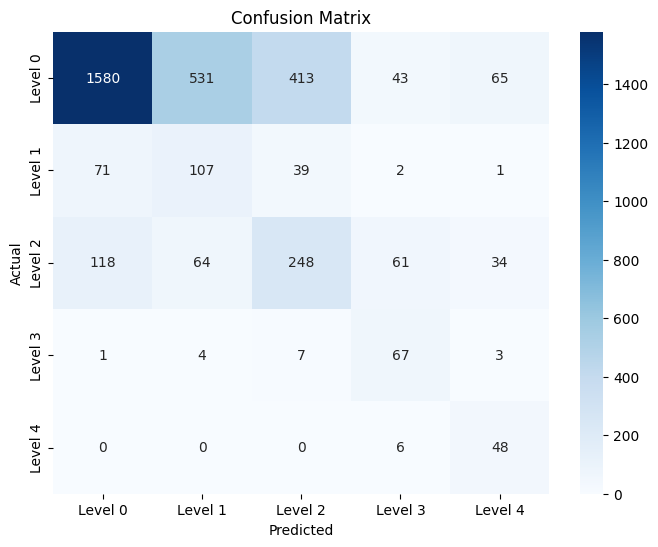

In [ ]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
cm_fig = plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Level 0', 'Level 1', 'Level 2', 'Level 3', 'Level 4'],
            yticklabels=['Level 0', 'Level 1', 'Level 2', 'Level 3', 'Level 4'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')

plt.show()

# Close the figure
plt.close(cm_fig)

## ROC Curves

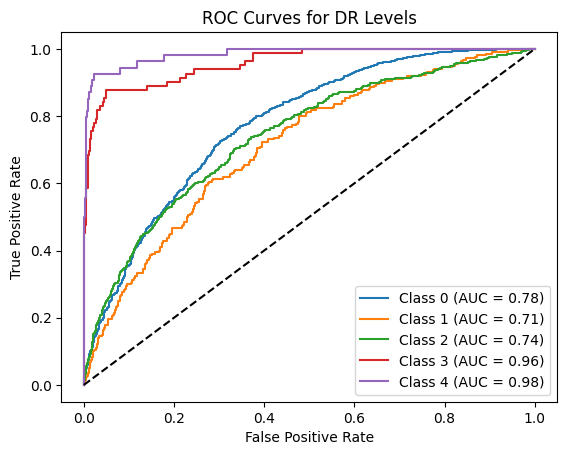

In [ ]:
from sklearn.preprocessing import label_binarize

# Binarize the labels
all_labels_bin = label_binarize(all_labels, classes=[0, 1, 2, 3, 4])
all_probs = np.array(all_probs)

# Compute ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
    roc_auc[i] = roc_auc_score(all_labels_bin[:, i], all_probs[:, i])

# Plot ROC curves
roc_fig = plt.figure()
for i in range(5):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves for DR Levels')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

plt.show()

# Close the figure
plt.close(roc_fig)

# Other

## Function to free memory

In [ ]:
def free_memory():
    """
    Attempts to free up memory by deleting variables and running Python's garbage collector.
    """
    gc.collect()
    for device_id in range(torch.cuda.device_count()):
        torch.cuda.set_device(device_id)
        torch.cuda.empty_cache()
    gc.collect()

## Run One training and validation batch to check bugs

In [ ]:
# Load components
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
trainer_config['fast_dev_run']=True
model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.prepare_data()
trainer.fit(lightning_module, dm)

INFO:lightning_fabric.utilities.seed:Seed set to 42


NameError: name 'load_all_configs' is not defined

## Find Learning Rate

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_w

Epoch 1: Val_Loss: 2.30, Val_Metric: 0.08 | 

Finding best initial lr:   0%|          | 0/30 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.0031622776601683794
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_0040228f-0599-4840-b176-4e1d81982b58.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_0040228f-0599-4840-b176-4e1d81982b58.ckpt


Train_Loss: 1.52, Train_Metric: 0.54
0.0031622776601683794


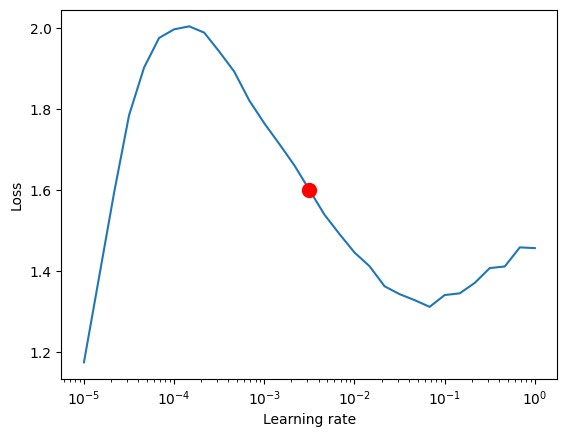

In [ ]:
# Load components
free_memory()
seed_everything(42)
model_config, data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
trainer_config['max_epochs']=5
data_module_config['data_module']['batch_size']=64

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.setup()
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(lightning_module, datamodule=dm, min_lr=1e-5, max_lr=1, num_training=30, mode='exponential')
fig = lr_finder.plot(suggest=True)
new_lr = lr_finder.suggestion()
print(new_lr)


# Scrapwork

In [ ]:
for name, module in model.named_modules():
    print(name)


features
features.0
features.0.0
features.0.1
features.0.2
features.1
features.1.0
features.1.0.block
features.1.0.block.0
features.1.0.block.0.0
features.1.0.block.0.1
features.1.0.block.0.2
features.1.0.block.1
features.1.0.block.1.avgpool
features.1.0.block.1.fc1
features.1.0.block.1.fc2
features.1.0.block.1.activation
features.1.0.block.1.scale_activation
features.1.0.block.2
features.1.0.block.2.0
features.1.0.block.2.1
features.1.0.stochastic_depth
features.1.1
features.1.1.block
features.1.1.block.0
features.1.1.block.0.0
features.1.1.block.0.1
features.1.1.block.0.2
features.1.1.block.1
features.1.1.block.1.avgpool
features.1.1.block.1.fc1
features.1.1.block.1.fc2
features.1.1.block.1.activation
features.1.1.block.1.scale_activation
features.1.1.block.2
features.1.1.block.2.0
features.1.1.block.2.1
features.1.1.stochastic_depth
features.2
features.2.0
features.2.0.block
features.2.0.block.0
features.2.0.block.0.0
features.2.0.block.0.1
features.2.0.block.0.2
features.2.0.block